In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random, pathlib
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '/net/scratch/tianh/explain_teach')
import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen

Matplotlib is building the font cache; this may take a moment.


In [2]:
distrators = ["tail size", "texture"]

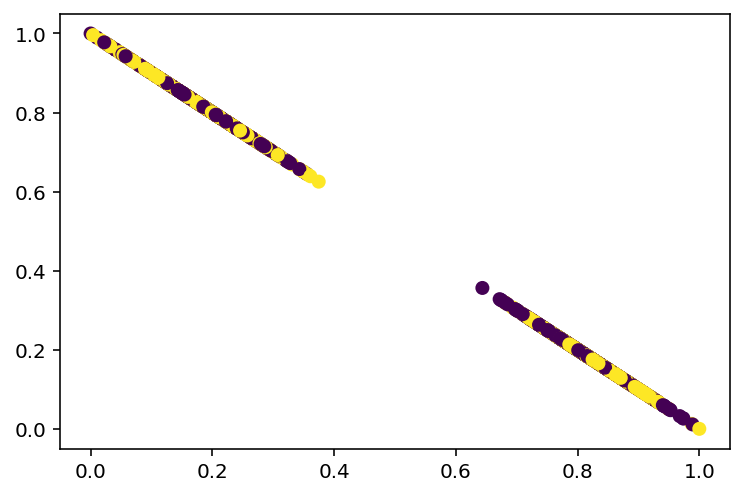

In [20]:
df = pd.read_csv("../datasets/wv_3d_square/df.csv")
plt.scatter(df[distrators[0]], df[distrators[1]], c=df["label"])

In [ ]:
pickle.dump(df[distrators].to_numpy(), open("distractors_linear.pkl","wb"))

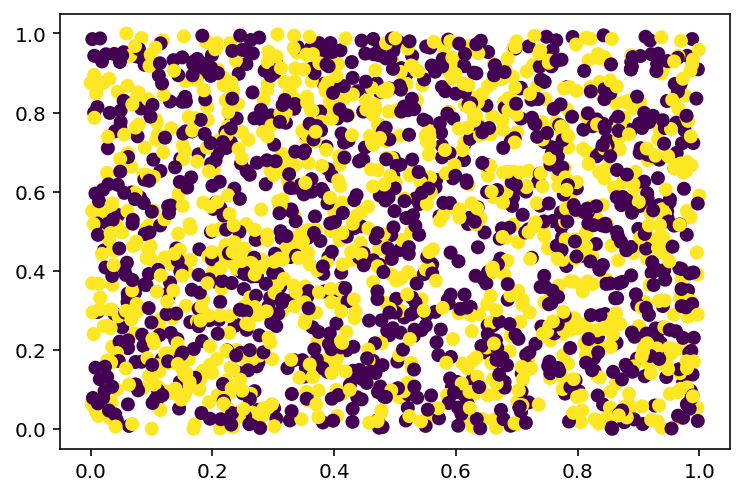

In [4]:
df = pd.read_csv("../datasets/wv_linear_sm/df.csv")
plt.scatter(df[distrators[0]], df[distrators[1]], c=df["label"])

In [23]:
pickle.dump(df[distrators].to_numpy(), open("distractors_random.pkl","wb"))

In [16]:
X = np.load("/net/scratch/tianh/explain_teach/data/datasets/wv_linear_sm/linear_sm.npz")["X"]
y = np.load("/net/scratch/tianh/explain_teach/data/datasets/wv_linear_sm/linear_sm.npz")["y"]

In [17]:
distractors = pickle.load(open("distractors_linear.pkl","rb"))


In [18]:
X = np.hstack([X[:,:2],distractors])

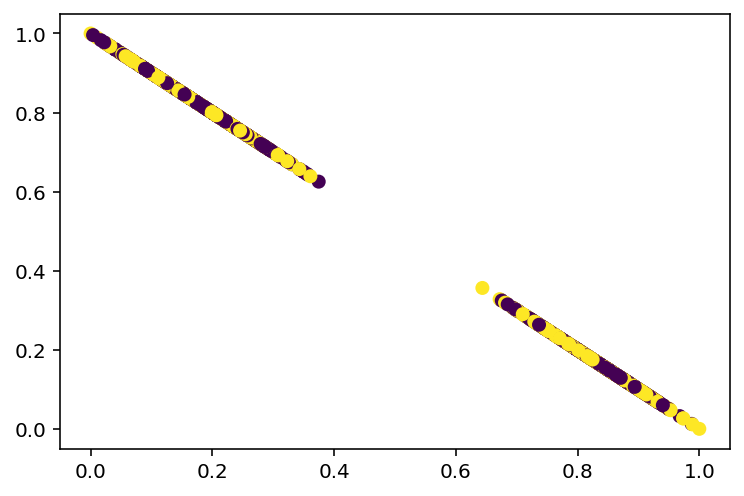

In [18]:
plt.scatter(X[:,2],X[:,3], c=y)


In [21]:
np.savez("/net/scratch/tianh/explain_teach/data/datasets/wv_linear_sm_0/linear_sm_0.npz", X=X, y=y)

In [5]:
DATASET_SIZE = 2000
INFORMATIVE_F = 2
DISTRACTOR_F = 2
out_file = "syn_bm.npz"
data = "wv_linear_sm_0"
data_dir = f"datasets/{data}"


## informative features

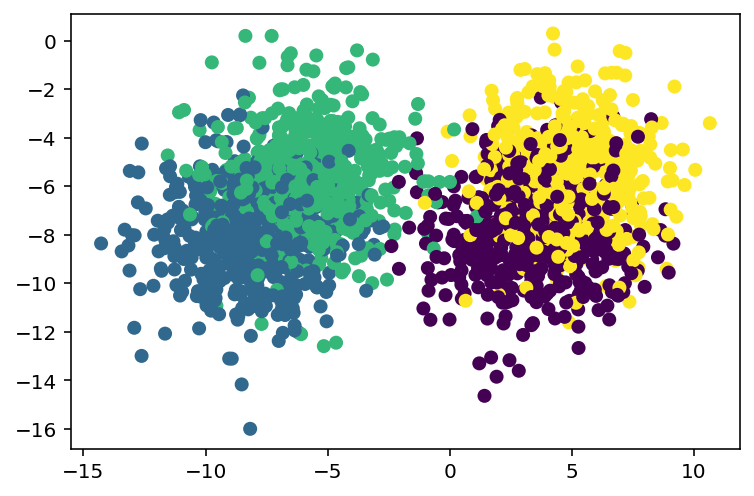

In [101]:
X,y = datasets.make_blobs(DATASET_SIZE, centers=4,cluster_std=2)
plt.scatter(X[:,0],X[:,1],c=y)

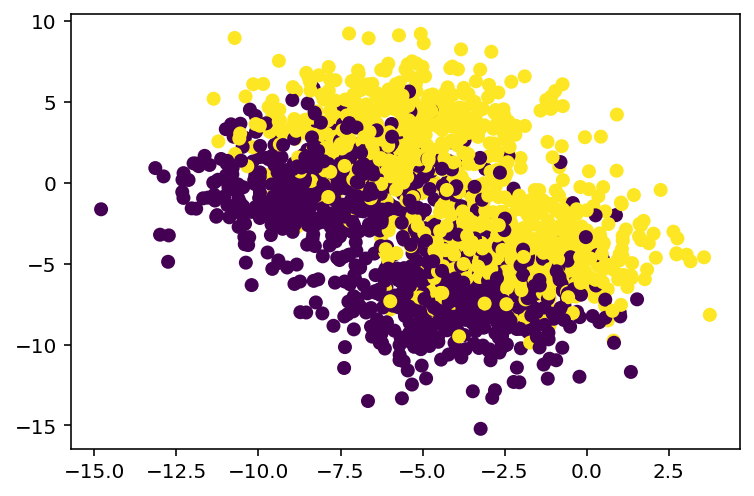

In [66]:
y_ = [0 if i in [0,3] else 1 for i in y]
plt.scatter(X[:,0],X[:,1],c=y_)


## distracting features

In [6]:
x3x4 = np.random.random([DATASET_SIZE,DISTRACTOR_F])
X = np.hstack([X,x3x4])

In [123]:
normalized_X = [normalize(X[:,i]) for i in range(X.shape[1])]
normalized_X = np.vstack(normalized_X).T

In [125]:
np.savez(out_file, X=normalized_X, y=y)

In [7]:
X = np.load("syn_bm.npz")["X"]
y = np.load("syn_bm.npz")["y"]

## gen df

In [2]:
X = np.load("/net/scratch/tianh/explain_teach/data/datasets/wv_linear_sm_0/linear_sm_0.npz")["X"]
y = np.load("/net/scratch/tianh/explain_teach/data/datasets/wv_linear_sm_0/linear_sm_0.npz")["y"]

In [6]:
features = ["head size","body size","tail size","texture"]
df = pd.DataFrame(X, columns=features)
df.insert(0, "label", y)

In [7]:
img_id = []
for i in range(DATASET_SIZE):
    if i < 10:
        img = f"00{i}.png"
    elif i >= 10 and i < 100:
        img = f"0{i}.png"
    else:
        img = f"{i}.png"
    img_id.append(img)
df.insert(0, "img_id", img_id)

In [8]:
data_dir = f"../datasets/{data}"
pathlib.Path(data_dir).mkdir(parents=True, exist_ok=True)
df.to_csv(os.path.join(data_dir,"df.csv"),index=False)

## borderless plot

In [9]:
features = ["head size","body size"]
assert(len(df)==DATASET_SIZE)

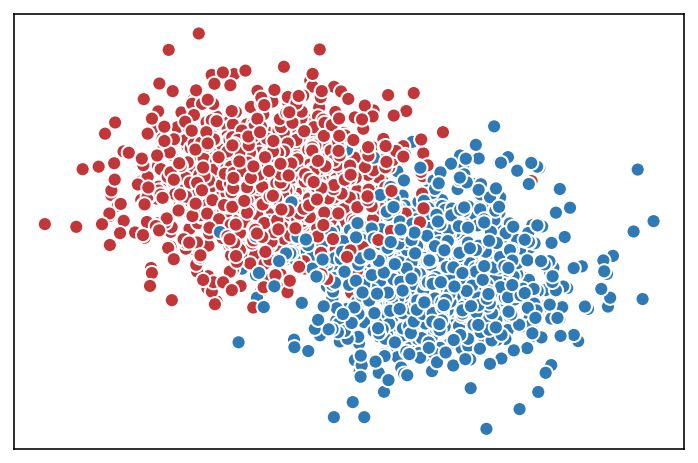

In [10]:
plt.scatter(df[features[0]],df[features[1]], c=df["label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

## pseudo label

In [38]:
data = "wv_squarelin"

In [28]:
def plot_boundary(X, y, w, b):
    plt.scatter(X[:,0],X[:,1], s=50,c=y,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)

    xd = np.array([-5,5])
    yd = w*xd + b
    plt.plot(xd, yd, 'k', lw=3, ls='--')

    plt.xlim(min(X[:,0]),max(X[:,0]))
    plt.ylim(min(X[:,1]),max(X[:,1]))
    plt.show()

def gen_plabel(x, y, w, b):
    y_prime = w * x + b
    if y > y_prime: return 1
    else: return 0

In [34]:
df = pd.read_csv("datasets/wv_3d_square/df.csv")
features = ["head size","body size"]

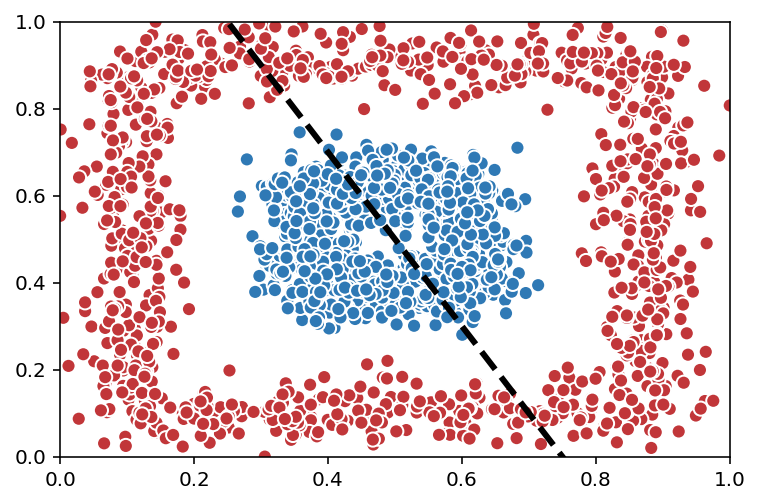

In [35]:
X = df[features].to_numpy()
y = df["label"]
w = -2
b = 1.5
plot_boundary(X, y, w, b)

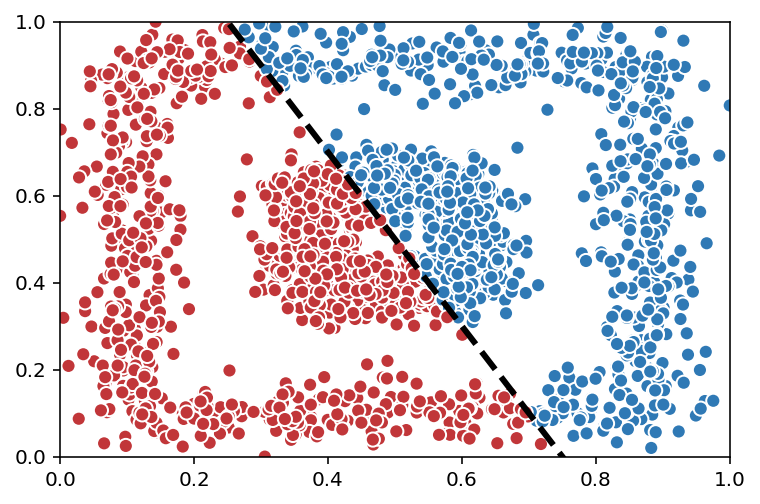

In [36]:
df['label'] = df.apply(lambda row : gen_plabel(row[features[0]], row[features[1]], w, b), axis = 1)
y = df["label"]
w = -2
b = 1.5
plot_boundary(X, y, w, b)

In [39]:
data_dir = f"datasets/{data}"
pathlib.Path(data_dir).mkdir(parents=True, exist_ok=True)
df.to_csv(os.path.join(data_dir,"df.csv"),index=False)

## data splitting

In [11]:
df = pd.read_csv(os.path.join(data_dir,"df.csv"))

In [12]:
raw_data_dir = os.path.join(data_dir, "raw_imgs")
split_dir =  os.path.join(data_dir, "data")
for i in range(DATASET_SIZE):
    img_id = df.iloc[i]["img_id"]
    label = df.iloc[i]["label"]
    src = os.path.join(raw_data_dir,img_id)
    dst = os.path.join(split_dir,str(label))
    pathlib.Path(dst).mkdir(parents=True, exist_ok=True)
    shutil.copy(src, dst)

In [13]:
total = np.arange(DATASET_SIZE)
valid = np.random.choice(total, int(DATASET_SIZE*0.2), replace=False)
total = np.setdiff1d(total, valid)
test = np.random.choice(total, int(DATASET_SIZE*0.2), replace=False)
total = np.setdiff1d(total, test)
train = total
train_df = df.iloc[train]
valid_df = df.iloc[valid]
test_df = df.iloc[test]

In [14]:
for split, df in zip(["train","valid","test"],[train_df,valid_df,test_df]):
    for i in range(len(df)):
        img_id = df.iloc[i]["img_id"]
        label = df.iloc[i]["label"]
        src = os.path.join(raw_data_dir,img_id)
        dst = os.path.join(data_dir,split,str(label))
        pathlib.Path(dst).mkdir(parents=True, exist_ok=True)
        shutil.copy(src,dst)

## synthetic features.pkl

In [15]:
df = pd.read_csv(os.path.join(data_dir,"df.csv"))

In [16]:
for split in ["train","valid","test"]:
    files = utils.dataset_filenames(os.path.join(data_dir,split))
    files = [x.split("/")[-1] for x in files[:,0]]
    features = np.array([list(df[df["img_id"]==f][["head size","body size","tail size","texture"]].iloc[0]) for f in files])
    pickle.dump(features,open(f"{data_dir}/{split}_features.pkl","wb"))